<a href="https://colab.research.google.com/github/NTT123/ai-notebooks/blob/master/Fourier_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An simple MLP network to predict an image using fourier features.

Source: [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/abs/2006.10739)


In [1]:
!pip3 install -Uqq opax pax3

In [2]:
fourier_feature = True #@param ["True", "False"] {type:"raw"}
noise_scale = 20.0 #@param ["0.1", "1.0", "5.0", "10.0", "20.0", "50.0"] {type:"raw"}

In [3]:
from PIL import Image
import requests
import jax
import jax.numpy as jnp
import numpy as np
import pax
import opax
import matplotlib.pyplot as plt
from typing import Sequence, Deque

In [4]:
# Load an image of a cat from the Internet
URL = "https://ichef.bbci.co.uk/news/976/cpsprodpb/12A9B/production/_111434467_gettyimages-1143489763.jpg"
im = Image.open(requests.get(URL, stream=True).raw)
width, height = im.size   # Get dimensions
new_width = new_height = min(width, height)
left = (width - new_width)//2
top = (height - new_height)//2
right = (width + new_width)//2
bottom = (height + new_height)//2

# Crop the center of the image
im = im.crop((left, top, right, bottom))
im = im.resize((256, 256))

In [5]:
# convert the image to numpy array
data = np.asarray(im)
data = data.astype(np.float32) / 255.
data.shape, data.dtype

((256, 256, 3), dtype('float32'))

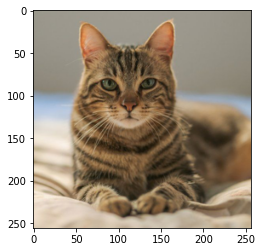

In [6]:
plt.imshow(data)
plt.show()

In [7]:
# create training dataset
x = np.linspace(0, 1, data.shape[0])
y = np.linspace(0, 1, data.shape[1])
xy = np.stack(np.meshgrid(x, y), axis=-1)
features = xy.reshape((-1, 2))
targets = data.reshape((-1, 3))
features.shape, targets.shape

((65536, 2), (65536, 3))

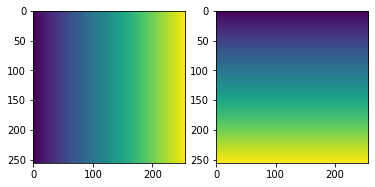

In [8]:
# check if we are generating coordinates correctly
plt.subplot(1, 2, 1)
plt.imshow(xy[..., 0])
plt.subplot(1, 2, 2)
plt.imshow(xy[..., 1])
plt.show()

In [9]:
def data_loader(x, y, batch_size):
    """
    return a data iter of mini-batches
    """
    while True:
        indices = np.random.permutation(x.shape[0])
        x = x[indices]
        y = y[indices]
        for i in range(0, x.shape[0] - batch_size, batch_size):
            j = i + batch_size
            yield x[i:j], y[i:j]

In [10]:
# testing
batch = next(data_loader(features, targets, 32))
batch[0].shape, batch[1].shape

((32, 2), (32, 3))

In [11]:
class FourierFeature(pax.Module):
    """
    Output fourier features from absolute positions.
    """
    def __init__(self, input_dim, output_dim, scale=10.0):
        self.B = jax.random.normal(
            pax.next_rng_key(), (input_dim, output_dim//2)
        ) * scale
    
    def __call__(self, x):
        x = jnp.matmul(x, self.B) * 2 * jnp.pi
        x = jnp.concatenate((jnp.cos(x), jnp.sin(x)), axis=-1)
        return x


class MLPImage(pax.Module):
    """
    A simple MLP network to output RGB image
    """
    def __init__(self, dims: Sequence[int], fourier_feature=False, noise_scale=1.0):
        super().__init__()
        layers = []
        self.fourier_feature = fourier_feature
        if fourier_feature:
            layers.append(FourierFeature(dims[0], dims[1], scale=noise_scale))
            dims = dims[1:]
        for input_dim, output_dim in zip(dims, dims[1:]):
            layers.append(pax.Linear(input_dim, output_dim))
            layers.append(pax.LayerNorm(output_dim, -1, True, True))
            layers.append(jax.nn.leaky_relu)
        del layers[-2]
        layers[-1] = jax.nn.sigmoid
        self.F = pax.Sequential(*layers)
    
    def __call__(self, x):
        return self.F(x)

In [12]:
def psnr():
    """
    Peak signal to noise ratio
    """
    c = net(features).reshape((256, 256, 3))
    mse = jnp.mean(jnp.square(c - data))
    maxi2 = jnp.square(jnp.max(data))
    return 10 * jnp.log10(maxi2 / mse)

In [13]:
net = MLPImage([2, 256, 256, 3], fourier_feature=fourier_feature, noise_scale=noise_scale)
optim = opax.adam(1e-4).init(net.parameters())
data_iter = data_loader(features, targets, 64)

In [14]:
# train MLP model

def loss_fn(net, x, y):
    """
    Mean square error
    """
    y_hat = net(x)
    mse = jnp.mean(jnp.square(y_hat - y))
    return mse

@jax.jit
def train_step(net, optim, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(net, x, y)
    net, optim = opax.apply_gradients(net, optim, grads)
    return net, optim, loss

losses = Deque(maxlen=1000)

for i, (x, y) in enumerate(data_iter):
    net, optim, loss = train_step(net, optim, x, y)
    losses.append(loss)
    if i % 10000 == 0:
        loss = sum(losses) / len(losses)
        print(f"step {i:07d}  loss {loss:.5f}  PSNR {psnr():.3f}")
    if i > 200_000:
        break

step 0000000  loss 0.06836  PSNR 11.741
step 0010000  loss 0.00256  PSNR 26.612
step 0020000  loss 0.00078  PSNR 31.533
step 0030000  loss 0.00049  PSNR 33.604
step 0040000  loss 0.00037  PSNR 34.905
step 0050000  loss 0.00031  PSNR 35.458
step 0060000  loss 0.00027  PSNR 35.882
step 0070000  loss 0.00025  PSNR 36.323
step 0080000  loss 0.00023  PSNR 36.915
step 0090000  loss 0.00021  PSNR 36.962
step 0100000  loss 0.00020  PSNR 37.219
step 0110000  loss 0.00020  PSNR 37.487
step 0120000  loss 0.00019  PSNR 37.782
step 0130000  loss 0.00018  PSNR 37.859
step 0140000  loss 0.00018  PSNR 37.744
step 0150000  loss 0.00017  PSNR 37.860
step 0160000  loss 0.00016  PSNR 38.186
step 0170000  loss 0.00016  PSNR 38.381
step 0180000  loss 0.00016  PSNR 38.270
step 0190000  loss 0.00015  PSNR 38.336
step 0200000  loss 0.00015  PSNR 38.495


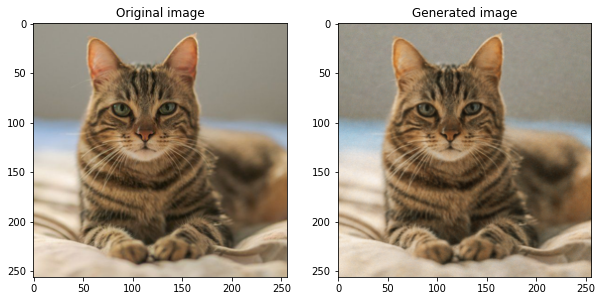

In [15]:
# plot final result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(data)
plt.title("Original image")
plt.subplot(1, 2, 2)
c = net(features).reshape((256, 256, 3)) 
plt.imshow(c)
plt.title("Generated image")
plt.show()